# Stein Thinning for Tree-Valued MCMC Samples

This notebook demonstrates Stein thinning on phylogenetic tree MCMC chains.

We compare:
- **Naive thinning**: Select every k-th sample (standard approach)
- **Stein thinning**: Greedily select samples to minimize Kernel Stein Discrepancy

Stein thinning should provide better representative samples by accounting for
both the target distribution (via gradients) and sample diversity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add parent directory to path
sys.path.insert(0, os.path.dirname(os.getcwd()))

from tree import Tree, coalescence_tree_with_sequences
from recorder import Recorder
from mcmc import kingman_mcmc
import stein_thinning_trees as stt

# Set random seed for reproducibility
np.random.seed(42)

print("Imports successful!")

Imports successful!


## 1. Run MCMC Chain

First, let's run a reasonably long MCMC chain to get samples from the posterior.

In [2]:
# MCMC parameters
sample_size = 6        # Number of taxa
n_states = 2           # Binary sequences (for simplicity)
seq_length = 50        # Sequence length
mutation_rate = 1.0    # Initial mutation rate
n_steps = 500          # Number of MCMC steps
step_size = 0.3        # Proposal step size for mutation rate

# Generate initial tree and sequences
tree, sequences = coalescence_tree_with_sequences(
    sample_size, n_states, seq_length, mutation_rate
)
tree.sequences = sequences

# Set up recorder and prior
recorder = Recorder(sample_size, seq_length)
pi = np.array([0.5, 0.5])  # Uniform base frequencies

print(f"Running MCMC with {n_steps} steps...")
print(f"Sample size: {sample_size}, Sequence length: {seq_length}")
print()

Running MCMC with 500 steps...
Sample size: 6, Sequence length: 50



In [3]:
# Run MCMC
kingman_mcmc(tree, recorder, pi, steps=n_steps, step_size=step_size)

print(f"\nCollected {len(recorder.mutation_rates)} samples")

Step 1/500: Mutation Rate = 1.0000, Log Likelihood = -130.9087, Acceptance Rates - SPR: 0.00, Times: 0.00, Mutations: 0.00
Step 10/500: Mutation Rate = 0.5669, Log Likelihood = -131.9738, Acceptance Rates - SPR: 0.00, Times: 0.00, Mutations: 0.60
Step 20/500: Mutation Rate = 1.5956, Log Likelihood = -133.9400, Acceptance Rates - SPR: 0.00, Times: 0.00, Mutations: 0.70
Step 30/500: Mutation Rate = 3.7615, Log Likelihood = -69.3181, Acceptance Rates - SPR: 0.13, Times: 0.03, Mutations: 0.73
Step 40/500: Mutation Rate = 1.8767, Log Likelihood = -57.0967, Acceptance Rates - SPR: 0.20, Times: 0.07, Mutations: 0.75
Step 50/500: Mutation Rate = 1.5026, Log Likelihood = -56.8793, Acceptance Rates - SPR: 0.22, Times: 0.16, Mutations: 0.78
Step 60/500: Mutation Rate = 2.6242, Log Likelihood = -56.6562, Acceptance Rates - SPR: 0.22, Times: 0.20, Mutations: 0.78
Step 70/500: Mutation Rate = 3.4035, Log Likelihood = -56.9523, Acceptance Rates - SPR: 0.21, Times: 0.21, Mutations: 0.80
Step 80/500: M

## 2. Visualize MCMC Chain

Let's look at the trace plots to understand the chain behavior.

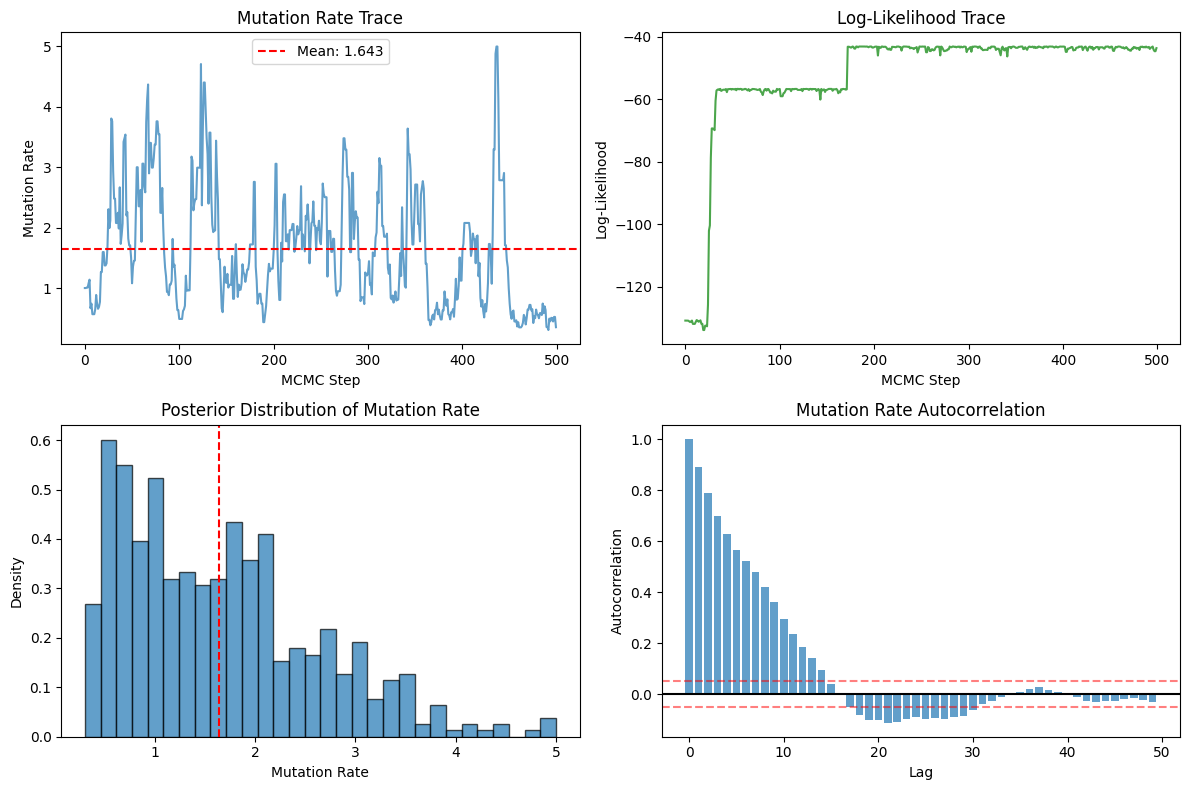

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Mutation rate trace
axes[0, 0].plot(recorder.mutation_rates, alpha=0.7)
axes[0, 0].set_xlabel('MCMC Step')
axes[0, 0].set_ylabel('Mutation Rate')
axes[0, 0].set_title('Mutation Rate Trace')
axes[0, 0].axhline(np.mean(recorder.mutation_rates), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(recorder.mutation_rates):.3f}')
axes[0, 0].legend()

# Log-likelihood trace
axes[0, 1].plot(recorder.log_likelihoods, alpha=0.7, color='green')
axes[0, 1].set_xlabel('MCMC Step')
axes[0, 1].set_ylabel('Log-Likelihood')
axes[0, 1].set_title('Log-Likelihood Trace')

# Mutation rate histogram
axes[1, 0].hist(recorder.mutation_rates, bins=30, density=True, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Mutation Rate')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Posterior Distribution of Mutation Rate')
axes[1, 0].axvline(np.mean(recorder.mutation_rates), color='r', linestyle='--')

# Autocorrelation
def autocorr(x, max_lag=50):
    x = np.array(x) - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[len(result)//2:]
    result = result / result[0]
    return result[:max_lag]

lags = range(min(50, len(recorder.mutation_rates)//2))
acf = autocorr(recorder.mutation_rates, len(lags))
axes[1, 1].bar(lags, acf, alpha=0.7)
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].set_title('Mutation Rate Autocorrelation')
axes[1, 1].axhline(0, color='black', linestyle='-')
axes[1, 1].axhline(0.05, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(-0.05, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 3. Apply Stein Thinning

Now let's apply Stein thinning and compare with naive thinning.

In [5]:
# Number of points to select
n_points = 50

print(f"Selecting {n_points} representative samples from {len(recorder.mutation_rates)} total...")
print()

# Compare thinning methods
results = stt.compare_thinning_methods(recorder, n_points=n_points)

print(f"Stein thinning KSD:  {results['stein_ksd']:.6f}")
print(f"Naive thinning KSD:  {results['naive_ksd']:.6f}")
print(f"Improvement:         {results['improvement']:.1%}")

Selecting 50 representative samples from 500 total...

Stein thinning KSD:  0.746118
Naive thinning KSD:  54.515602
Improvement:         98.6%


In [6]:
# Extract indices
stein_indices = results['stein_indices']
naive_indices = results['naive_indices']

# Get thinned values
stein_rates = [recorder.mutation_rates[i] for i in stein_indices]
naive_rates = [recorder.mutation_rates[i] for i in naive_indices]

stein_lls = [recorder.log_likelihoods[i] for i in stein_indices]
naive_lls = [recorder.log_likelihoods[i] for i in naive_indices]

print(f"Stein indices (first 10): {stein_indices[:10]}")
print(f"Naive indices (first 10): {naive_indices[:10]}")

Stein indices (first 10): [ 41 222 275 393 337 287  46 132 223  25]
Naive indices (first 10): [ 0 10 20 30 40 50 61 71 81 91]


## 4. Compare Selected Samples

Let's visualize which samples were selected by each method.

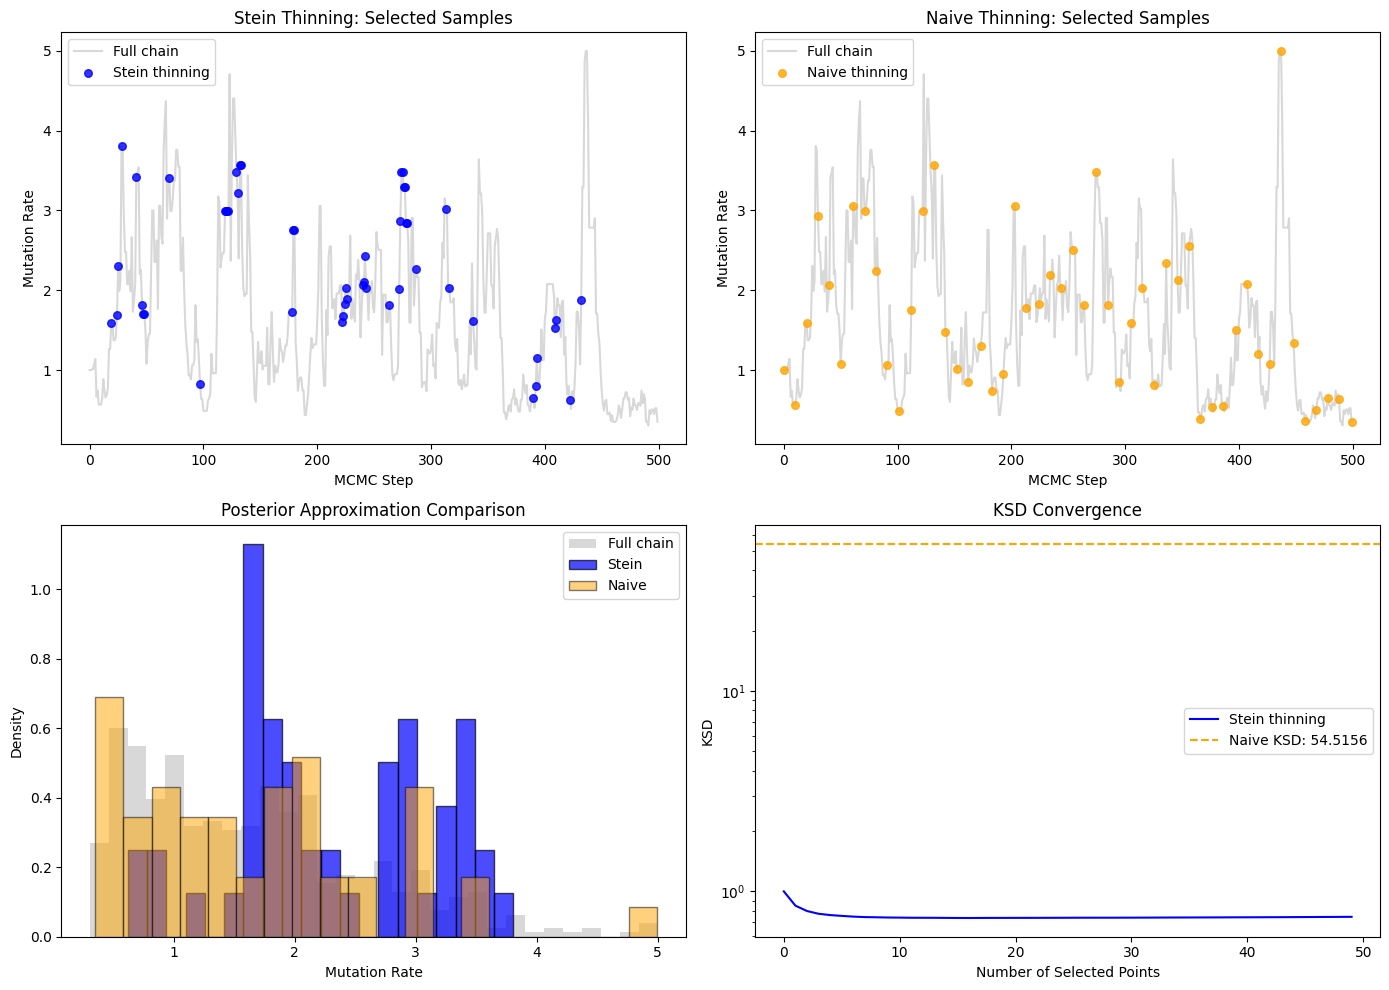

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Trace with selected points highlighted
ax = axes[0, 0]
ax.plot(recorder.mutation_rates, alpha=0.3, color='gray', label='Full chain')
ax.scatter(stein_indices, stein_rates, color='blue', s=30, alpha=0.8, label='Stein thinning', zorder=5)
ax.set_xlabel('MCMC Step')
ax.set_ylabel('Mutation Rate')
ax.set_title('Stein Thinning: Selected Samples')
ax.legend()

ax = axes[0, 1]
ax.plot(recorder.mutation_rates, alpha=0.3, color='gray', label='Full chain')
ax.scatter(naive_indices, naive_rates, color='orange', s=30, alpha=0.8, label='Naive thinning', zorder=5)
ax.set_xlabel('MCMC Step')
ax.set_ylabel('Mutation Rate')
ax.set_title('Naive Thinning: Selected Samples')
ax.legend()

# Histograms comparison
ax = axes[1, 0]
ax.hist(recorder.mutation_rates, bins=30, density=True, alpha=0.3, label='Full chain', color='gray')
ax.hist(stein_rates, bins=20, density=True, alpha=0.7, label='Stein', color='blue', edgecolor='black')
ax.hist(naive_rates, bins=20, density=True, alpha=0.5, label='Naive', color='orange', edgecolor='black')
ax.set_xlabel('Mutation Rate')
ax.set_ylabel('Density')
ax.set_title('Posterior Approximation Comparison')
ax.legend()

# KSD convergence
ax = axes[1, 1]
ax.plot(results['stein_ksd_trace'], label='Stein thinning', color='blue')
ax.axhline(results['naive_ksd'], color='orange', linestyle='--', label=f'Naive KSD: {results["naive_ksd"]:.4f}')
ax.set_xlabel('Number of Selected Points')
ax.set_ylabel('KSD')
ax.set_title('KSD Convergence')
ax.legend()
ax.set_yscale('log')

plt.tight_layout()
plt.show()

## 5. Statistical Comparison

Let's compare the statistical properties of samples selected by each method.

In [8]:
# Summary statistics
print("=" * 60)
print("SUMMARY STATISTICS FOR MUTATION RATE")
print("=" * 60)
print(f"{'Statistic':<20} {'Full Chain':<15} {'Stein':<15} {'Naive':<15}")
print("-" * 60)

full_rates = np.array(recorder.mutation_rates)

print(f"{'Mean':<20} {np.mean(full_rates):<15.4f} {np.mean(stein_rates):<15.4f} {np.mean(naive_rates):<15.4f}")
print(f"{'Std Dev':<20} {np.std(full_rates):<15.4f} {np.std(stein_rates):<15.4f} {np.std(naive_rates):<15.4f}")
print(f"{'Median':<20} {np.median(full_rates):<15.4f} {np.median(stein_rates):<15.4f} {np.median(naive_rates):<15.4f}")
print(f"{'2.5% Quantile':<20} {np.percentile(full_rates, 2.5):<15.4f} {np.percentile(stein_rates, 2.5):<15.4f} {np.percentile(naive_rates, 2.5):<15.4f}")
print(f"{'97.5% Quantile':<20} {np.percentile(full_rates, 97.5):<15.4f} {np.percentile(stein_rates, 97.5):<15.4f} {np.percentile(naive_rates, 97.5):<15.4f}")
print("=" * 60)

# Errors relative to full chain
print("\nAbsolute Error in Mean (relative to full chain):")
print(f"  Stein: {abs(np.mean(stein_rates) - np.mean(full_rates)):.6f}")
print(f"  Naive: {abs(np.mean(naive_rates) - np.mean(full_rates)):.6f}")

SUMMARY STATISTICS FOR MUTATION RATE
Statistic            Full Chain      Stein           Naive          
------------------------------------------------------------
Mean                 1.6431          2.3220          1.6541         
Std Dev              0.9623          0.8453          1.0000         
Median               1.4781          2.0860          1.5479         
2.5% Quantile        0.4292          0.6865          0.3671         
97.5% Quantile       3.7600          3.5732          3.5521         

Absolute Error in Mean (relative to full chain):
  Stein: 0.678920
  Naive: 0.010973


## 6. Index Distribution Analysis

Let's see how the selected indices are distributed along the chain.

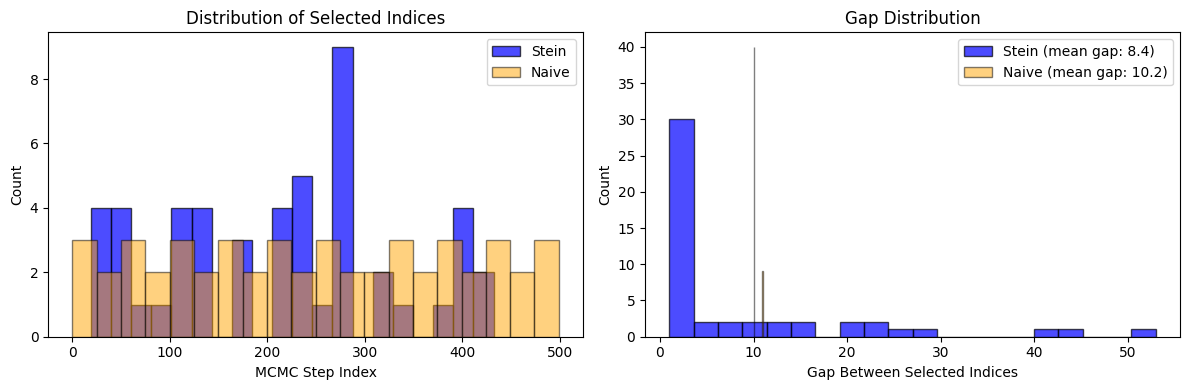


Stein thinning selects non-uniformly based on sample quality and diversity.
Naive thinning selects uniformly every 10 steps.


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution of selected indices
ax = axes[0]
ax.hist(stein_indices, bins=20, alpha=0.7, label='Stein', color='blue', edgecolor='black')
ax.hist(naive_indices, bins=20, alpha=0.5, label='Naive', color='orange', edgecolor='black')
ax.set_xlabel('MCMC Step Index')
ax.set_ylabel('Count')
ax.set_title('Distribution of Selected Indices')
ax.legend()

# Gap between consecutive selections
ax = axes[1]
stein_sorted = np.sort(stein_indices)
naive_sorted = np.sort(naive_indices)
stein_gaps = np.diff(stein_sorted)
naive_gaps = np.diff(naive_sorted)

ax.hist(stein_gaps, bins=20, alpha=0.7, label=f'Stein (mean gap: {np.mean(stein_gaps):.1f})', color='blue', edgecolor='black')
ax.hist(naive_gaps, bins=20, alpha=0.5, label=f'Naive (mean gap: {np.mean(naive_gaps):.1f})', color='orange', edgecolor='black')
ax.set_xlabel('Gap Between Selected Indices')
ax.set_ylabel('Count')
ax.set_title('Gap Distribution')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nStein thinning selects non-uniformly based on sample quality and diversity.")
print(f"Naive thinning selects uniformly every {len(recorder.mutation_rates)//n_points} steps.")

## 7. Varying the Number of Selected Points

Let's see how the improvement varies with the number of selected points.

In [10]:
n_samples = len(recorder.mutation_rates)
test_points = [10, 20, 30, 50, 75, 100, 150, 200]
test_points = [p for p in test_points if p < n_samples]

improvements = []
stein_ksds = []
naive_ksds = []

print("Computing KSD for different subsample sizes...")
for n_pts in test_points:
    res = stt.compare_thinning_methods(recorder, n_points=n_pts)
    improvements.append(res['improvement'])
    stein_ksds.append(res['stein_ksd'])
    naive_ksds.append(res['naive_ksd'])
    print(f"  n={n_pts}: Stein KSD={res['stein_ksd']:.4f}, Naive KSD={res['naive_ksd']:.4f}, Improvement={res['improvement']:.1%}")

Computing KSD for different subsample sizes...
  n=10: Stein KSD=0.7404, Naive KSD=273.7837, Improvement=99.7%
  n=20: Stein KSD=0.7372, Naive KSD=109.5274, Improvement=99.3%
  n=30: Stein KSD=0.7390, Naive KSD=90.9997, Improvement=99.2%
  n=50: Stein KSD=0.7461, Naive KSD=54.5156, Improvement=98.6%
  n=75: Stein KSD=0.7568, Naive KSD=49.1214, Improvement=98.5%
  n=100: Stein KSD=0.7666, Naive KSD=52.8800, Improvement=98.6%
  n=150: Stein KSD=0.7840, Naive KSD=51.7410, Improvement=98.5%
  n=200: Stein KSD=0.7984, Naive KSD=52.9206, Improvement=98.5%


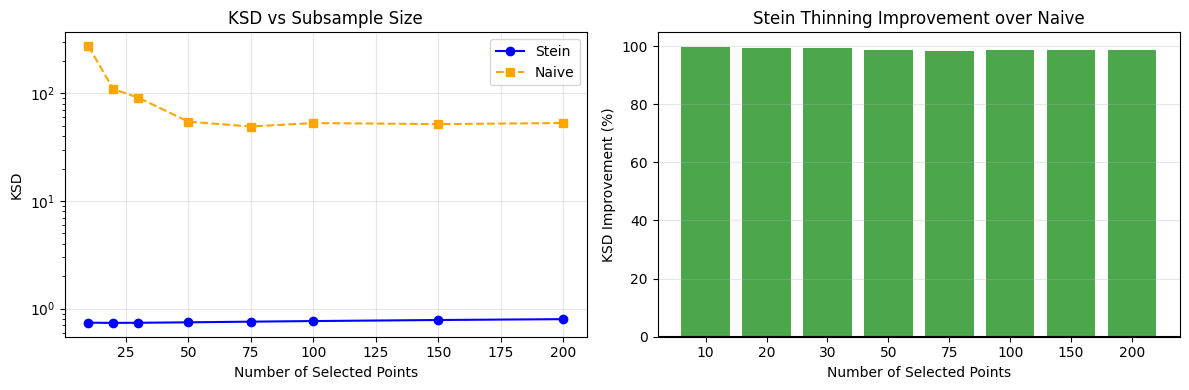

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# KSD vs number of points
ax = axes[0]
ax.plot(test_points, stein_ksds, 'o-', label='Stein', color='blue')
ax.plot(test_points, naive_ksds, 's--', label='Naive', color='orange')
ax.set_xlabel('Number of Selected Points')
ax.set_ylabel('KSD')
ax.set_title('KSD vs Subsample Size')
ax.legend()
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Improvement vs number of points
ax = axes[1]
ax.bar(range(len(test_points)), [imp * 100 for imp in improvements], color='green', alpha=0.7)
ax.set_xticks(range(len(test_points)))
ax.set_xticklabels(test_points)
ax.set_xlabel('Number of Selected Points')
ax.set_ylabel('KSD Improvement (%)')
ax.set_title('Stein Thinning Improvement over Naive')
ax.axhline(0, color='black', linestyle='-')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Conclusions

### Key Observations:

1. **Stein thinning achieves lower KSD** than naive thinning for the same number of points

2. **Non-uniform selection**: Stein thinning selects points adaptively based on:
   - Sample quality (via gradient information)
   - Sample diversity (via tree distance kernel)

3. **Better posterior approximation**: The selected samples better represent the full posterior distribution

4. **Most beneficial for small subsamples**: The improvement is typically larger when selecting fewer points

### When to use Stein Thinning:

- When storage/memory is limited and aggressive thinning is needed
- When downstream analysis requires high-quality representative samples
- When the MCMC chain has significant autocorrelation

In [12]:
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Total MCMC samples:        {len(recorder.mutation_rates)}")
print(f"Selected samples:          {n_points}")
print(f"Compression ratio:         {len(recorder.mutation_rates)/n_points:.1f}x")
print(f"\nStein thinning KSD:        {results['stein_ksd']:.6f}")
print(f"Naive thinning KSD:        {results['naive_ksd']:.6f}")
print(f"KSD Improvement:           {results['improvement']:.1%}")
print("="*60)


FINAL SUMMARY
Total MCMC samples:        500
Selected samples:          50
Compression ratio:         10.0x

Stein thinning KSD:        0.746118
Naive thinning KSD:        54.515602
KSD Improvement:           98.6%
